# *Optimized Secure Landing Identification for Unmanned Aircraft Systems*

This project proposes a method for detecting drone landing areas through semantic segmentation of aerial images. We train deep learning models, such as UNet and PSPNet, on the Semantic Drone Dataset to reliably distinguish between different terrain types. Our optimized UNet model demonstrates the highest accuracy, effectively identifying safe landing zones and avoiding obstacles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

import glob
import os

import cv2
import scipy.ndimage as ndi

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

#### Data Path

In [2]:
path = r"C:\Users\nilav\Downloads\dl\new\Segmentation-of-Aerial-Images-main\Segmentation-of-Aerial-Images-main\archive\\"

### Loading images from the Specified Path

In [3]:
# Paths
mask_path = path + "RGB_color_image_masks/*.png"
img_path = path + "original_images/*.jpg"

mask_paths = sorted(glob.glob(mask_path))
img_paths = sorted(glob.glob(img_path))


# Classes and palette
class_df = pd.read_csv(path + "class_dict_seg.csv")
class_df['RGB'] = class_df[[' r', ' g', ' b']].values.tolist()

classes = class_df["name"].tolist()
RGBs = class_df["RGB"].tolist()

normalized_palette = np.round(np.array(RGBs, dtype=np.float32) / 255 , 5)
normalized_palette_tuples = [tuple(color) for color in normalized_palette.tolist()]
classes_palette = dict(zip(normalized_palette_tuples, classes))
classes_to_index = {cls: idx for idx, cls in enumerate(classes)}

In [4]:
print(img_path)
print(mask_path)
print(len(img_paths))

C:\Users\nilav\Downloads\dl\new\Segmentation-of-Aerial-Images-main\Segmentation-of-Aerial-Images-main\archive\\original_images/*.jpg
C:\Users\nilav\Downloads\dl\new\Segmentation-of-Aerial-Images-main\Segmentation-of-Aerial-Images-main\archive\\RGB_color_image_masks/*.png
400


In [5]:
print("RGB masks set size:", len(mask_paths))
print("Original images set size:", len(img_paths))
print("Number of classes:", len(classes))

RGB masks set size: 400
Original images set size: 400
Number of classes: 24


In [33]:
normalized_palette

array([[0.     , 0.     , 0.     ],
       [0.50196, 0.25098, 0.50196],
       [0.5098 , 0.29804, 0.     ],
       [0.     , 0.4    , 0.     ],
       [0.43922, 0.40392, 0.34118],
       [0.1098 , 0.16471, 0.65882],
       [0.18824, 0.16078, 0.11765],
       [0.     , 0.19608, 0.34902],
       [0.41961, 0.55686, 0.13725],
       [0.27451, 0.27451, 0.27451],
       [0.4    , 0.4    , 0.61176],
       [0.99608, 0.89412, 0.04706],
       [0.99608, 0.58039, 0.04706],
       [0.7451 , 0.6    , 0.6    ],
       [0.6    , 0.6    , 0.6    ],
       [1.     , 0.08627, 0.37647],
       [0.4    , 0.2    , 0.     ],
       [0.03529, 0.56078, 0.58824],
       [0.46667, 0.04314, 0.12549],
       [0.2    , 0.2    , 0.     ],
       [0.7451 , 0.98039, 0.7451 ],
       [0.43922, 0.58824, 0.57255],
       [0.00784, 0.52941, 0.45098],
       [1.     , 0.     , 0.     ]], dtype=float32)

In [6]:
class_df.head()

,name,r,g,b,RGB
0,unlabeled,0,0,0,"[0, 0, 0]"
1,paved-area,128,64,128,"[128, 64, 128]"
2,dirt,130,76,0,"[130, 76, 0]"
3,grass,0,102,0,"[0, 102, 0]"
4,gravel,112,103,87,"[112, 103, 87]"


### Classes And corresponding RGB-values

In [7]:
print("Classes:", classes)
print("RGB Values:", RGBs)

Classes: ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']
RGB Values: [[0, 0, 0], [128, 64, 128], [130, 76, 0], [0, 102, 0], [112, 103, 87], [28, 42, 168], [48, 41, 30], [0, 50, 89], [107, 142, 35], [70, 70, 70], [102, 102, 156], [254, 228, 12], [254, 148, 12], [190, 153, 153], [153, 153, 153], [255, 22, 96], [102, 51, 0], [9, 143, 150], [119, 11, 32], [51, 51, 0], [190, 250, 190], [112, 150, 146], [2, 135, 115], [255, 0, 0]]


### Splitting Data into Training, Validation, and Test Sets

##### Validation
- Prevent overfitting
- Regularization

In [8]:
# Train, val and test split

# Split the data into train and temp (test + validation)
mask_train, mask_temp, img_train, img_temp = train_test_split(mask_paths, img_paths, test_size=0.25, random_state=42)

# Further split the temp data into validation and test
mask_val, mask_test, img_val, img_test = train_test_split(mask_temp, img_temp, test_size=0.5, random_state=42)

In [9]:
# Print the sizes of each split
print(f"Training set size: {len(mask_train)}")
print(f"Validation set size: {len(mask_val)}")
print(f"Test set size: {len(mask_test)}")

Training set size: 300
Validation set size: 50
Test set size: 50


### Visualizing Masked Image Color Palette for Drone Image Classes

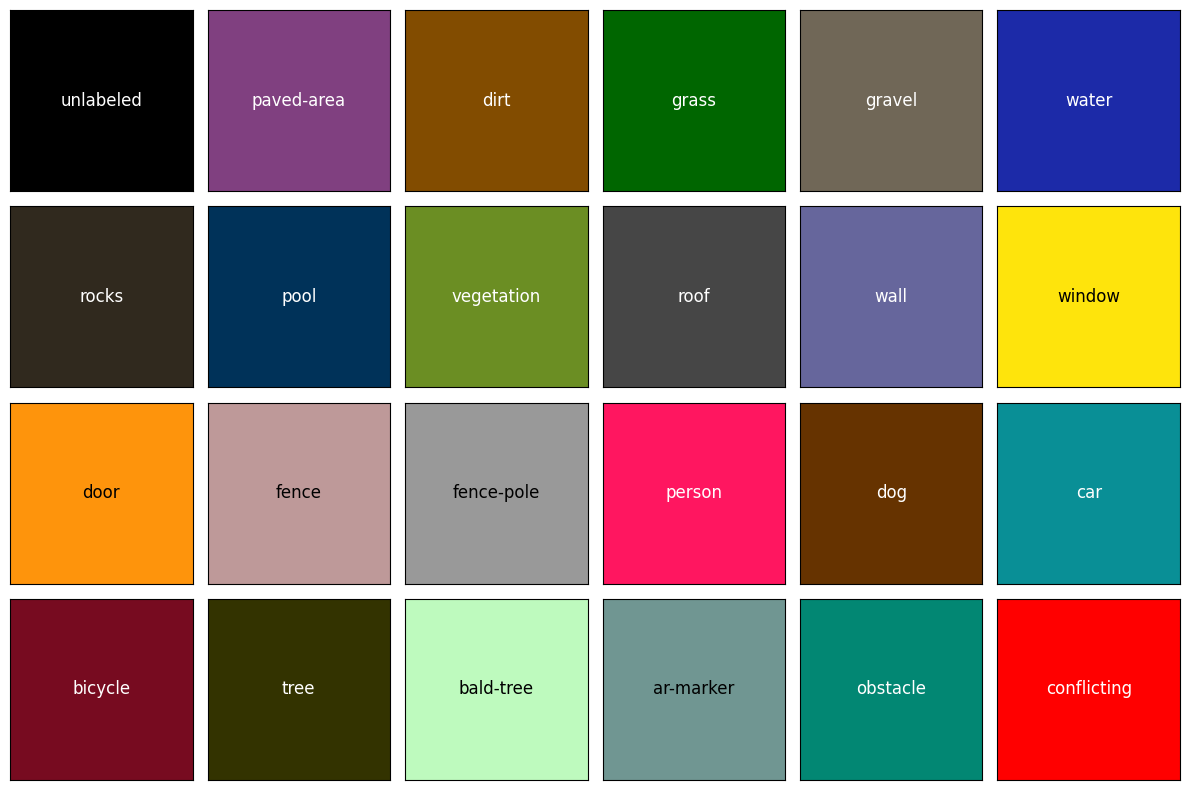

In [10]:
# Palette and classes

fig, axes = plt.subplots(4, 6, figsize=(12, 8))

axes = axes.flatten()
for ax, cls, rgb in zip(axes, classes, normalized_palette):
    ax.set_facecolor(rgb)
    ax.text(0.5, 0.5, cls, ha='center', va='center', fontsize=12, color='white' if sum(rgb) < 1.5 else 'black')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Sample Original And Masked Image

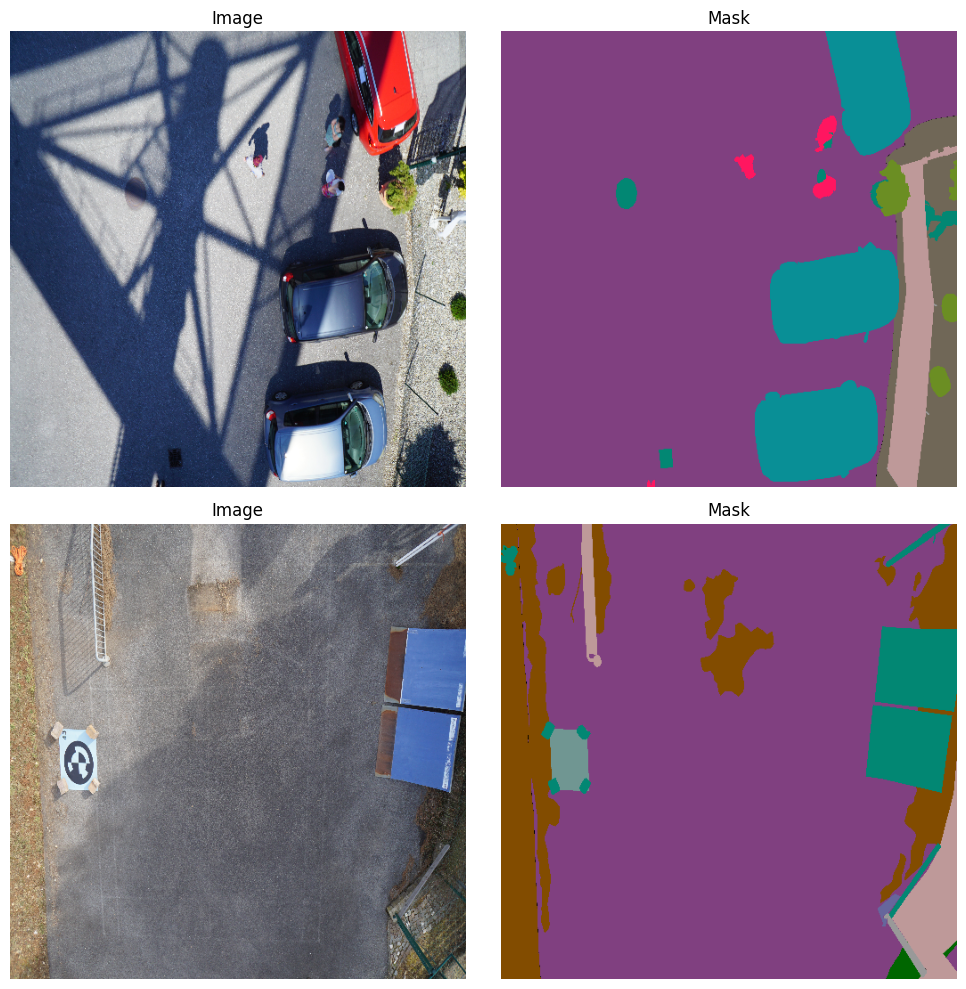

In [11]:
# Sample image

def load_image(path):
    """
    Loads an image or mask, same preprocessing used later for training but higher res vor visualization
    """
    image = cv2.imread(path)
    image = cv2.resize(image, (512,512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    return image

def plot_image_mask_pairs(img_paths, mask_paths, n=1):
    """
    Plots n samples of image-mask pairs.
    """
    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))

    for i in range(n):
        idx = np.random.randint(0, len(img_paths))
        img = load_image(img_paths[idx])
        mask = load_image(mask_paths[idx])

        if n == 1:
            axes[0].imshow(img)
            axes[0].set_title('Image')
            axes[1].imshow(mask)
            axes[1].set_title('Mask')
            axes[0].axis('off')
            axes[1].axis('off')
        else:
            axes[i, 0].imshow(img)
            axes[i, 0].set_title('Image')
            axes[i, 1].imshow(mask)
            axes[i, 1].set_title('Mask')
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
    return mask


mask= plot_image_mask_pairs(img_train, mask_train, n=2)


### Analyzing Class Distribution in Masked Drone Image

- **find_closest_color(pixel, palette)**: Finds the closest matching color in the palette for each pixel to handle slight color variations.
  
- **class_counter(mask, palette, classes_palette)**: Counts occurrences of each class in the mask image and calculates their percentages.

- **plot_class_distribution(df)**: Plots a bar chart to visually represent the distribution of classes in the mask image.

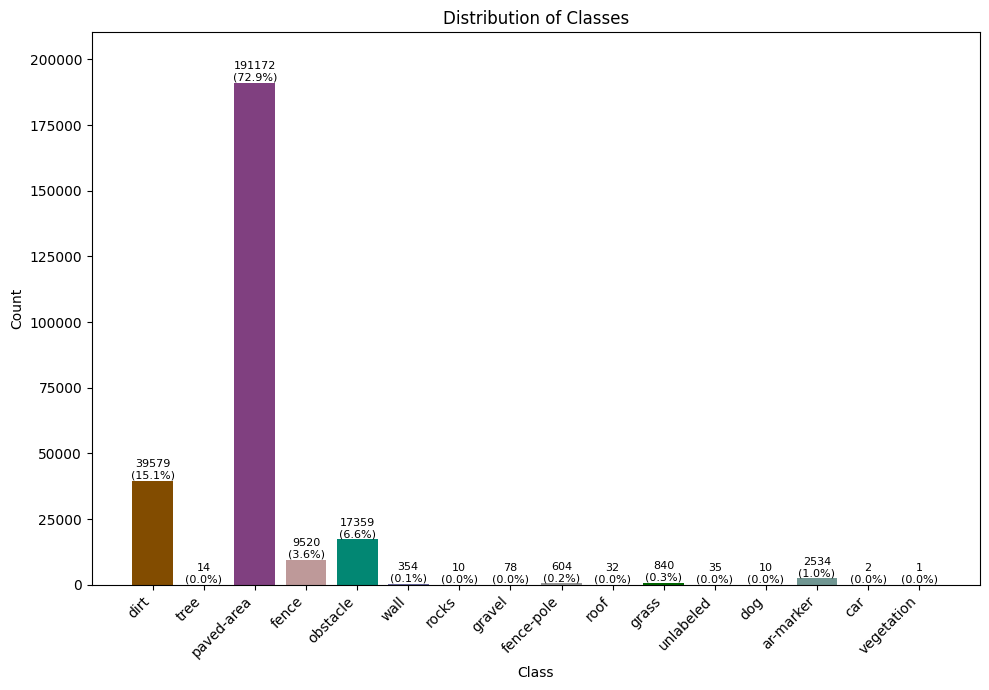

In [12]:
# Frequency of classes (last sampled image above)

def find_closest_color(pixel, palette):
    '''
    Matches each pixel to the closest in the normalized palette
    '''
    distances = np.linalg.norm(palette - pixel, axis=1)
    return tuple(palette[np.argmin(distances)])


def class_counter(mask, palette, classes_palette):
    """
    Counts the occurrences of each class in the mask annotation
    """
    pixels = [find_closest_color(pixel, palette) for row in mask for pixel in row]
    pixel_counts = Counter(pixels)

    df = pd.DataFrame(list(pixel_counts.items()), columns=['RGB_norm', 'Count'])
    df['Class'] = df['RGB_norm'].map(classes_palette)
    df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

    return df

def plot_class_distribution(df):
    """
    Plots the distribution of classes
    """
    plt.figure(figsize=(10,7))
    bars = plt.bar(df['Class'], df['Count'], color=[tuple(rgb) for rgb in df['RGB_norm']])

    # Percentages on top of bars
    for bar, count in zip(bars, df['Count']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{count}\n({count / df["Count"].sum() * 100:.1f}%)',
                 ha='center', va='bottom', fontsize=8)

    plt.ylim(0, max(df['Count']) + max(df['Count']) * 0.10)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

df = class_counter(mask, normalized_palette, classes_palette)
plot_class_distribution(df)

### Encoding Mask RGB Values to Integer Labels for Model Training

In [ ]:
# Dataset class creation

class DroneDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        '''
        Resizes images and masks to 256x256 for computational efficiency, converts
        to RGB colormap and normalizes into 0-1 range
        '''
        image = cv2.imread(self.image_paths[idx])
        image = cv2.resize(image, (256, 256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.resize(mask, (256, 256))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        '''
        Encodes mask RGB values to integer labels 0-9, required for the chosen criterion
        '''

        # each pixel is labeled by a label, 
        # each pixel from masked-image is give a label. 
        # Label is taken from RGB, which tells what is the 
        # basically giving label for each pixel.

        mask_labels = np.zeros((256, 256), dtype=np.int64)
        for i, color in enumerate(RGBs):
                mask_labels[(mask == color).all(axis=-1)] = i

        if self.transform:
            augmented = self.transform(image=image, mask=mask_labels)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
    
    

### Data Augmentation for Training and Tensor Conversion for Validation
- This code defines transformations for data augmentation in the training set using Albumentations, including random flipping, rotation, and tensor conversion. These augmentations help improve model generalization by introducing variability.

In [16]:
# Spatial-level data augmentation (with albumentations)
# Data augmentation is a technique used to artificially increase the size of the
#  dataset and introduce variability, helping the model generalize better. 

# Need: During training, it's important to expose the model to a variety of transformations of 
# the input data, as this prevents the model from overfitting to the specific examples in the training
#  set and helps it learn more generalizable features.


train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
])


# The validation dataset should reflect the kind of data the model will encounter in a real-world scenario.
# Applying augmentations to the validation set could introduce noise or inconsistencies that would not represent 
# actual variations in the data, leading to misleading validation 
# performance.

val_transforms = A.Compose([
    ToTensorV2()
])

# Alternative: no augmentation

'''
train_transforms = A.Compose([
    ToTensorV2()
])

val_transforms = A.Compose([
    ToTensorV2()
])
'''

'\ntrain_transforms = A.Compose([\n    ToTensorV2()\n])\n\nval_transforms = A.Compose([\n    ToTensorV2()\n])\n'

### Creating Datasets and Defining DataLoaders for Training, Validation, and Testing

In [ ]:
# Create the datasets
# The dataset

train_dataset = DroneDataset(img_train, mask_train, transform=train_transforms)
val_dataset = DroneDataset(img_val, mask_val, transform=val_transforms)
test_dataset = DroneDataset(img_test, mask_test, transform=val_transforms)

### Fipped Images

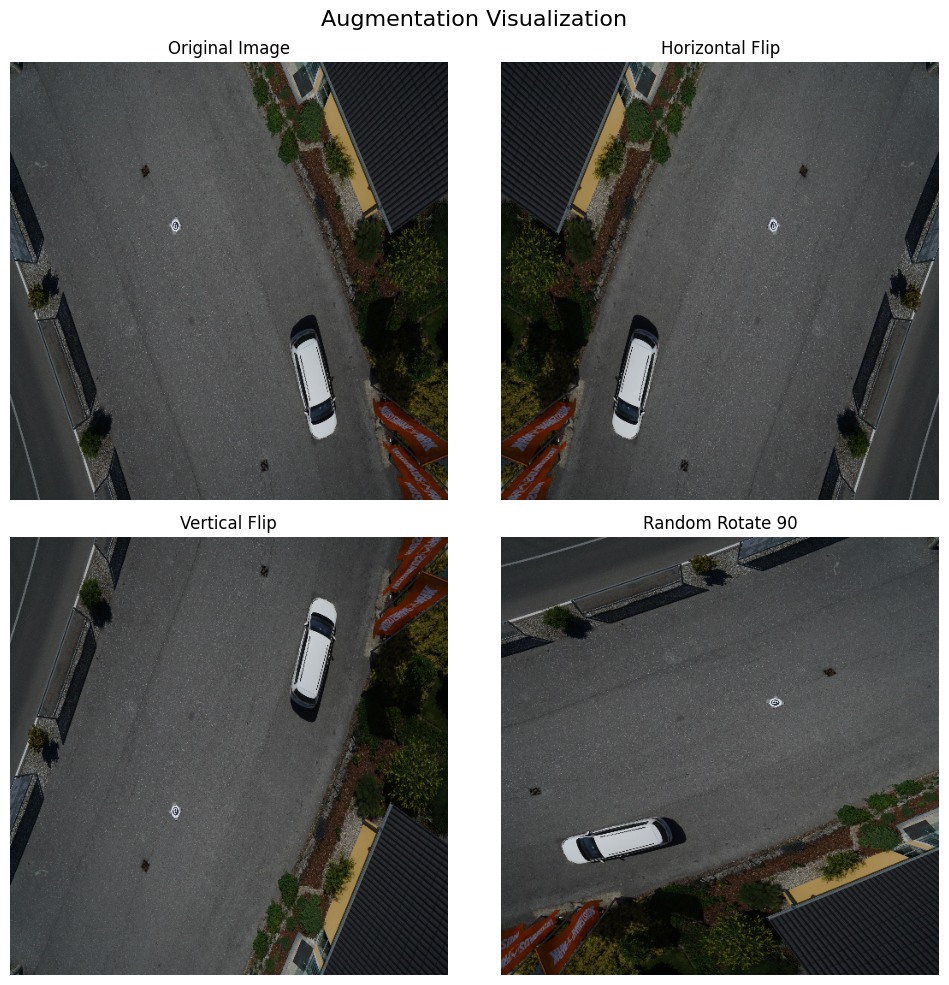

In [29]:
# Visualization

def apply_transform(image, transform):
    '''
    Applies a transformation to an image and returns the transformed image
    '''
    augmented = transform(image=image)
    return augmented['image']

def plot_transformed_images(img_path, transforms):
    '''
    Plots original and augmented images in a grid
    '''
    image = load_image(img_path)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Augmentation Visualization', fontsize=16)

    # Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Apply each transformation and plot
    transform_list = [
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.RandomRotate90(p=1)] #,
        #A.GaussianBlur(blur_limit=(3, 9), p=1),
        #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
        #A.RandomCrop(height=256, width=256, p=1),
        #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
        #A.GridDistortion(num_steps=10, distort_limit=0.3, p=1)]
    titles = ['Horizontal Flip', 'Vertical Flip',
              'Random Rotate 90' ] #, 'Gaussian Blur', 'Random Brightness/Contrast',
              #'Random Crop','Color Jitter','Grid Distortion']

    for i, (transform, title) in enumerate(zip(transform_list, titles)):
        row = (i + 1) // 2
        col = (i + 1) % 2
        transformed_image = apply_transform(image, transform)
        axes[row, col].imshow(transformed_image)
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

sample_img_path = img_train[np.random.randint(len(img_train))]
plot_transformed_images(sample_img_path, train_transforms)

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])


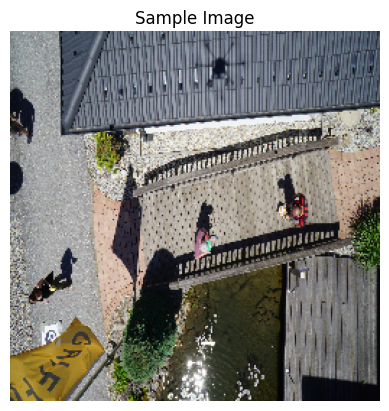

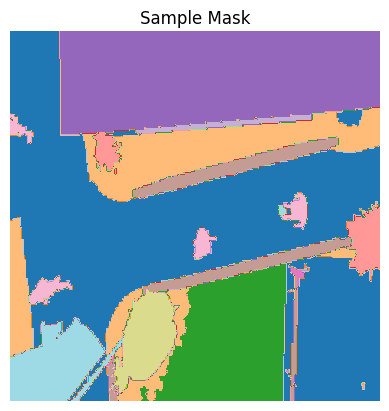

In [25]:
# Access a single sample from the dataset
image, mask = train_dataset[0]  # Index 0 to get the first image and mask

# Display image and mask to check values
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

# If you'd like to visualize the image and mask (requires matplotlib and PIL)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Display image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Converting tensor to numpy for visualization
plt.title("Sample Image")
plt.axis('off')
plt.show()

# Mask (Display): The roads might be in red, the buildings in blue, and the trees in green.
# The background could be white, with other smaller objects in different colors.
# olor Map (cmap='tab20'): The tab20 colormap is used for visualizing these class labels. 
# Each class (e.g., tree, building, road) is assigned a unique color from the 20 colors available in 
# the colormap, which helps to easily distinguish different segments of the image.

# Display mask
plt.imshow(mask, cmap='tab20')  # Display mask with colormap for better visibility
plt.title("Sample Mask")
plt.axis('off')
plt.show()